In [2]:
## perform imports and set-up
import numpy as np
import pandas as pd
import statsmodels.api as sm

from scipy import stats
from matplotlib import pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.style.use('ggplot') # emulate pretty r-style plots

In [3]:
boston = pd.read_csv("../DataForLab/Boston.csv")

Simple Scatterplot with `plt`

beta= [ 34.554 , -0.95 ]
R=-0.738, p_value=0.000, stderr=0.039


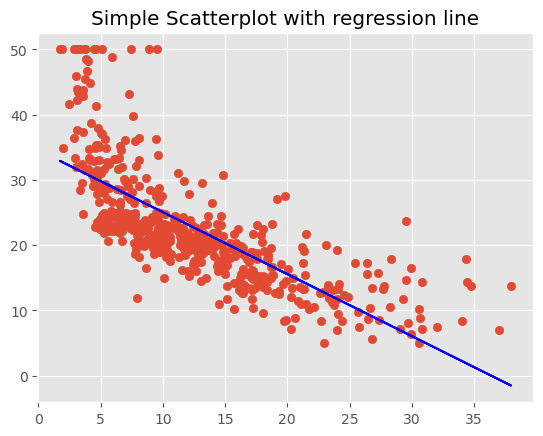

In [4]:
scatter1Fig, scatter1 = plt.subplots()
scatter1.scatter(x=boston["lstat"],y=boston["medv"])
scatter1.set_title("Simple Scatterplot with regression line")

beta1, beta0, r_value, p_value, stderr = stats.linregress(boston["lstat"],y=boston["medv"])

# add the estimation to the data plot
scatter1.plot(boston["lstat"], beta0 + beta1*boston["lstat"],color='b', label="OLS")


# print the regression estimates returned from scipy
print('beta= [',round(beta0,3),',', round(beta1,3),']')
print('R={0:.3f}, p_value={1:.3f}, stderr={2:.3f}'.format(r_value, p_value, stderr))


Scatterplot with statsmodel

In [5]:
#define the predictor
X = boston["lstat"]

# We add a constant of 1 for the intercept term
X = sm.add_constant(X)

# we need to add constant because Y = mX + C
# see documentation https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.html

# set the dependent variable
Y = boston["medv"]

# create the model instance and fit
linear_model = sm.OLS(Y,X)
linear_results = linear_model.fit()
# data about the model is stored in summary
print(linear_results.summary())


                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Thu, 25 May 2023   Prob (F-statistic):           5.08e-88
Time:                        20:51:39   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.5538      0.563     61.415      0.0

In [8]:
# statsmodels includes functions for getting the prediction and confidence intervals.

# Get prediction interval for a given x
prstd, iv_l, iv_u = wls_prediction_std(linear_results)

# statsmodels also includes the confidence intervals for the fitted values (i.e. the mean fits)
# but they are buried in the results of summary table function.
from statsmodels.stats.outliers_influence import summary_table

# call the summary table at a (1-alpha)100% confidence interval level
simpleTable, data, column_names = summary_table(linear_results, alpha=0.05)


# Data contains the confidence intervals we want but we need to make sure we get the right
# columns so lets print off the names
print('column_names: ', column_names)

# Get confidence intervals for a given x
predicted_mean_ci_low, predicted_mean_ci_high = data[:,4:6].T
# the array slice means , take all rows, choose only index 4 to index 5 columns
# .T transposes the array / flip it against its diagonal https://numpy.org/doc/stable/reference/generated/numpy.transpose.html#numpy.transpose
# we basically expressed the 2 terms in corresponding to i-th row rather than them currently in array of arrays of pairs

column_names:  ['Obs', 'Dep Var\nPopulation', 'Predicted\nValue', 'Std Error\nMean Predict', 'Mean ci\n95% low', 'Mean ci\n95% upp', 'Predict ci\n95% low', 'Predict ci\n95% upp', 'Residual', 'Std Error\nResidual', 'Student\nResidual', "Cook's\nD"]
[[29.02529896 30.61989124]
 [25.2652456  26.47553397]
 [29.87347656 31.57680741]
 ...
 [28.43428101 29.95684404]
 [27.67960321 29.11543892]
 [26.41425913 27.72064482]]
[[29.02529896 25.2652456  29.87347656 ... 28.43428101 27.67960321
  26.41425913]
 [30.61989124 26.47553397 31.57680741 ... 29.95684404 29.11543892
  27.72064482]]


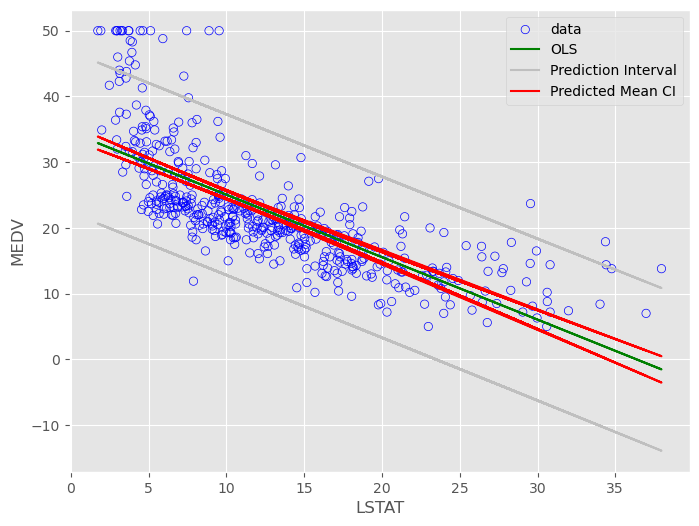

In [10]:
# Create a plot to plot the data, OLS estimate, prediction and confidence intervals
fig, ax = plt.subplots()

# get numpy array values from dataframe
x = boston["lstat"]
y = boston["medv"]

# Plot the data
ax.scatter(x, y, facecolors='none', edgecolors='b', label="data")
# plot the models fitted values
ax.plot(x, linear_results.fittedvalues, 'g', label="OLS")

# plot the high and low prediction intervals
ax.plot(x, iv_u, color='0.75',label="Prediction Interval")
ax.plot(x, iv_l, color='0.75')

# plot the high and low mean confidence intervals
ax.plot(x,predicted_mean_ci_low, 'r', label="Predicted Mean CI")
ax.plot(x,predicted_mean_ci_high,'r')

ax.legend(loc='best');

plt.xlabel('LSTAT');
plt.ylabel('MEDV');